# Machine Learning and Natural Language Processing
## Text Classification with Scikit-learn, Python and NLTK

Este projeto trata de alguns passos necessários para a criação de um _pipeline_ de processamento de linguagem natural (NLP):

1. Processamento de Texto
    * Limpeza
    * Normalização
    * Tokenização
    * Remoção de _stop words_
    * Marcação de partes da fala
    * Reconhecimento de entidades nomeadas
    * _Stemming_ and _Lemmatization_
2. Extração de Características
    * _Bag of Words_
    * _TF-IDF_
    * _Word Embeddings_
3. Modelagem

### Como os _pipelines_ de NLP funcionam

Os três estágios de um _pipeline_ de NLP são: Processamento de Texto > Extração de Características > Modelagem.
* **Processamento:** é nesta fase que recebemos os dados brutos (que podem ser comentários do Facebook, tweets, denúncias do Atender.CAIXA, etc), limpamos, normalizamos e os convertemos para um formato adequado para a extração de características.
* **Extração de Características:** nesta fase devemos extrair e produzir uma representação das características de um modo apropriado ao tipo de tarefa de NLP que estamos tentando realizar e para o tipo de modelo que estamos planejando usar.
* **Modelagem:** depois que tudo está num formato adequado, podemos desenhar um modelo estatístico ou de _machine learning_ ajustar seus parâmetros aos dados de treinamento, usar os procedimentos de otimização e então usá-lo para fazer predições sobre dados ainda não vistos.

Note que este processo nem sempre é linear e pode requerer mais ou menos passos, dependendo da tarefa que você quer completar.

### Bibliotecas

A célula a seguir carrega as bibliotecas necessárias à execução do projeto.

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import nltk
import re
import string
from string import digits
from nltk.tokenize import word_tokenize
import json
import os
import pickle

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

### Dados

Para criar um modelo de classificação baseado em aprendizado supervisionado, precisamos carregar o _corpus_ com o comentário, que será vetorizado e a variável de saída. A princípio, utilizaremos como variável de saída a coluna `Sentiment`.

In [2]:
# Load the dataset
in_file = 'postagens_facebook.csv'

# If necessary, adjust the encoding and the other params to read the .csv file
# data = pd.read_csv(in_file, sep=';', encoding='latin1')
data = pd.read_csv(in_file, sep=',')
data = data[data.Sentiment.notnull()]
data = data.drop(data.columns[0], axis=1)

# Print the first few entries and the dataset dimensions
display(data.head())
print("The dataset has {} lines and {} columns".format(data.shape[0], data.shape[1]))

,Post,Comment,Likes,Sentiment,Tipo,Produto/Serviço
0,https://www.facebook.com/caixa/photos/a.333880...,"Que caixa e essa que vc deixar uma quantia lá,...",2,Negativo,Reclamação,Contas
1,https://www.facebook.com/caixa/photos/a.333880...,Olá sou cliente de vocês tenho uma conta poupa...,0,Neutro,Dúvida,Contas
2,https://www.facebook.com/caixa/photos/a.333880...,Gostaria de saber quando posso sacar o meu val...,0,Neutro,Dúvida,Outros/Não Especificado
3,https://www.facebook.com/caixa/photos/a.333880...,preciso de fazer o cpf de minha filha ela va...,1,Neutro,Dúvida,Outros/Não Especificado
4,https://www.facebook.com/caixa/photos/a.333880...,Bom dia!!!\nMoro em são paulo o meu cartão ven...,0,Neutro,Dúvida,Cartões


The dataset has 4335 lines and 6 columns


Na célula abaixo separamos as variáveis descritivas e de saída, e codificamos a variável `y` utilizando números inteiros.

In [3]:
# keep only words, remove numbers and special characters
# regex_pat = re.compile(r'[0-9!@#$%^&*()_+\-=\[\]{};\':"\\|,.<>\/?]', flags=re.IGNORECASE)

sentiment = {'Negativo': -1, 'Neutro': 0, 'Positivo': 1}

stopwords = nltk.corpus.stopwords.words('portuguese')

y = []

for i in data['Sentiment']:
    y.append(sentiment[i]) 
    #print(sentiment[i])

X = data.Comment.values.tolist()

### Limpeza

Dados textuais podem vir de uma grande variedade de fontes: a _web_, PDFs, documentos do Word, sistemas de reconhecimento de voz, etc. Nossa tarefa é extrair o texto simples, livre de quaisquer marcações específicas (tags HTML, links, emojis) ou construções que não são relevantes para a tarefa.

Também é importante observar que algumas características da nossa linguagem como capitalização, pontuação, e palavras comuns como artigos e preposições, embora ajudem a formar uma estrutura básica, nem sempre acrescentam muito valor semântico. Por isso, às vezes é melhor removê-los  para ajudar a reduzir a complexidade do modelo e os procedimentos necessários para realizar posteriormente.

Nesta etapa, vamos pré-processar o texto através dos seguintes passos:

1. **Limpar** itens irrelevantes, como tags HTML e emojis
2. **Normalizar** o texto, reduzindo todas as letras a minúsculas e removendo pontuação e caracteres especiais
3. Dividir o texto em palavras ou **tokens**
4. Remover palavras que são muito comuns, também conhecidas como **stop words**
5. Identificar diferentes **partes do discurso** e **entidades nomeadas**
6. Converter palavras para suas formas do dicionário, usando **stemming** e **lemmatization**

Depois de executar essas etapas, seu texto irá capturar a essência do que estava sendo transmitido em um formato mais fácil de se trabalhar.

In [4]:
def parse_sentence(sentence):
    tokens = word_tokenize(sentence)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    words = [word for word in tokens if word.isalpha]
    words = [word for word in tokens if len(word)>2]
    words = [word for word in words if not word in stopwords]
    return words

Para auxiliar no entendimento do modelo, uma boa prática é visualizar as palavras usadas nos comentários. Para isso, vamos fazer o _parse_ das sentenças e agrupar os tokens em vetores:

In [5]:
sentences = []

for sentence in X:
    sentences.append(parse_sentence(sentence))
    
all_words = []
for sentence in sentences:
    for word in sentence:
        all_words.append(word)

all_words = nltk.FreqDist(all_words)
print(all_words.most_common(100))

[('caixa', 1715), ('conta', 929), ('pra', 761), ('cartão', 743), ('dia', 631), ('saber', 589), ('direito', 537), ('fazer', 509), ('pis', 508), ('anos', 449), ('boa', 434), ('agência', 425), ('banco', 414), ('gostaria', 396), ('poupança', 389), ('faço', 380), ('dinheiro', 379), ('quero', 374), ('receber', 348), ('valor', 323), ('nada', 312), ('agora', 294), ('preciso', 271), ('atendimento', 261), ('tarde', 259), ('pois', 258), ('nao', 254), ('ter', 249), ('bom', 227), ('posso', 226), ('hoje', 225), ('ainda', 224), ('pode', 221), ('consigo', 219), ('boleto', 218), ('porque', 211), ('ser', 209), ('pagar', 204), ('crédito', 197), ('nunca', 196), ('dias', 190), ('casa', 188), ('ano', 186), ('olá', 184), ('favor', 181), ('financiamento', 181), ('desde', 181), ('vou', 176), ('noite', 175), ('pai', 175), ('agencia', 170), ('vcs', 170), ('fiz', 169), ('abrir', 168), ('saldo', 167), ('vai', 162), ('mensagem', 160), ('tudo', 160), ('carteira', 160), ('novo', 159), ('sistema', 158), ('meses', 154)

Em seguida, utilizamos uma nuvem de palavras como um recurso visual para facilitar a compreensão:

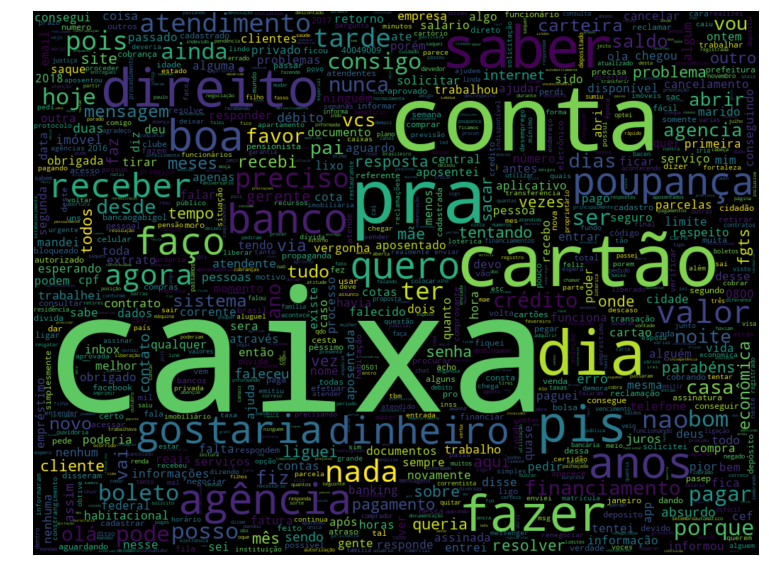

In [6]:
wordcloud = WordCloud(width=1024,height=768, max_words=1000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(all_words)

plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Dividindo os dados para treinamento e teste

Para validar a acurácia do modelo é importante separar um subconjunto de dados que será utilizado como massa de testes. Esses dados não podem ser visíveis ao algoritmo no momento do treinamento e deve verificar se o modelo foi capaz de compreender as nuances das sentenças com base nos comentários anteriores.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

# parse_sentence(X_train[1])

### Extraindo características dos comentários

Arquivos de texto ou, no nosso caso, comentários do Facebook são na verdade uma série de palavras (ordenadas). Para executar algoritmos de _machine learning_, nós precisamos converter o texto em uma notação que o computador é capaz de processar com mais facilidade: vetores numéricos. Para o nosso modelo, vamos usar **bag of words** ou bolsa de palavras. De modo simplificado, vamos segmentar cada sentença em palavras (dividindo nos espaços em branco) e contar o número de vezes que cada palavra aparece em cada documento, atribuindo um número identificador para essa palavra. Cada palavra no nosso dicionário corresponderá a uma _feature_.

In [8]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(3034, 7091)

No trecho de código acima, na linha `count_vect.fit_transform(X_train)`, nós estamos construindo o vocabulário ou um dicionário de palavras que podem aparecer no texto.

O problema é que contar apenas a frequência com que um determinado termo aparece em um documento pode causar uma distorção na interpretação dos dados, pois o peso atribuído a trechos de texto maiores seria superior que documentos mais curtos. Para evitar isto, nós podemos utilizar a frequência (__TF - Term Frequencies__), que representa o número de aparições da palavra em relação ao número total de palavras no documento.

Ainda, é possível reduzir o peso de palavras comuns a todos os documentos utilizando a metodologia __TF-IDF__ (_Term Frequency times Inverse DOcument Frequency_).

In [9]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3034, 7091)

### Executando algoritmos de _Machine Learning_

Há vários algoritmos que podem ser usados para classificação de texto. Para começar, podemos utilizar o mais simples ou que requer menos parâmetros de configuração: o _Naive Bayes (NB)_.

Para reduzir a quantidade de código, nós podemos construir o modelo na forma de um __Pipeline__:

In [10]:
stopwords = nltk.corpus.stopwords.words('portuguese')

text_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())])

text_clf = text_clf.fit(X_train, y_train)

Agora, nós vamos testar a performance do classificador _Naive Bayes_ no subconjunto de teste:

In [11]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7770945426594927

A acurácia que conseguimos foi de __~77.7%__, nada mal para um conjunto de dados de treinamento relativamente pequeno com um classificador _Naive_.

A seguir, vamos experimentar o algoritmo __Support Vector Machines (SVM)__ e tentar alcançar uma performance melhor:

In [36]:
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words=stopwords)),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(
                             loss='hinge',
                             penalty='l2',
                             alpha=1e-3,
                             max_iter=5,
                             random_state = 3
                         ))])

_ = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
np.mean(predicted_svm == y_test)

0.8293620292083013

A acurácia que conseguimos desta vez foi de __~83.93%__. Um pouquinho melhor!

### Utilizando _Grid Search_ para aprimorar o modelo

Praticamente todos os classificadores têm vários parâmetros que podem ser "tunados" para obter uma performance otimizada. A biblioteca _Scikit_ oferece uma ferramenta extramamente útil para testar várias combinações de parâmetros para obter o melhor resultado: o `GridSearchCV`.

Para consultar quais parâmetros podem ser ajustados em cada modelo, visite a página do [Scikit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

A seguir, vamos fazer o `GridSearchCV` usando o modelo _Naive Bayes_:

In [37]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
print("Best score: %s" % (gs_clf.best_score_))
gs_clf.best_params_

Best score: 0.8388266315095584


{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}

In [38]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3),
              'clf-svm__loss': ('hinge', 'modified_huber', 'perceptron'),
              'clf-svm__penalty': ('l2', 'l1', 'elasticnet'),
              'clf-svm__max_iter': range(10, 40, 10)
             }

gs_clf_svm = GridSearchCV(text_clf_svm, parameters, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
print("Best score: %s" % (gs_clf_svm.best_score_))
gs_clf_svm.best_params_

Best score: 0.8345418589321029


{'clf-svm__alpha': 0.001,
 'clf-svm__loss': 'modified_huber',
 'clf-svm__max_iter': 20,
 'clf-svm__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 2)}

In [40]:
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words=stopwords, ngram_range=(1, 2))),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(
                             loss='modified_huber',
                             penalty='l2',
                             alpha=0.001,
                             max_iter=30
                         ))])

_ = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
np.mean(predicted_svm == y_test)

0.8347425057647964

### Classificando textos

A seguir, utilizamos o modelo otimizado para realizar alguns testes de classificação:

In [124]:
comment = "atendimento"

predicted = text_clf_svm.predict([comment])
probability = text_clf_svm.predict_proba([comment])

print (json.dumps({"comment": comment,
                    "sentiment": list(sentiment.keys())[list(sentiment.values()).index(predicted)], 
                   "confidence": max(probability[0])}, 
                  sort_keys=False, indent=4, separators=(',', ': '), ensure_ascii=False))

{
    "comment": "atendimento",
    "sentiment": "Negativo",
    "confidence": 0.9928394431346553
}


### Exportando o modelo

A seguir, utilizamos o Pickle para serializar o modelo e prepará-lo para deploy.

In [137]:
directory = os.getcwd()

model = text_clf_svm
filename = 'model.pk'
with open(directory+'\\models\\'+filename, 'wb') as file:
    pickle.dump(model, file)